In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
target = df['NObeyesdad']
df = df.drop('NObeyesdad', axis=1)

df = df.copy(deep=True)
df['FAVC'] = df['FAVC'].apply(lambda x: int(x == "yes"))
df['SCC'] = df['SCC'].apply(lambda x: int(x == "yes"))
df['SMOKE'] = df['SMOKE'].apply(lambda x: int(x == "yes"))
df['family_history_with_overweight'] = \
    df['family_history_with_overweight'].apply(lambda x: int(x == "yes"))

df= pd.get_dummies(df, columns=['Gender', 'MTRANS', 'CAEC', 'CALC'], dtype=int)
scaler = StandardScaler()
df = scaler.fit_transform(df)

## Дерево принятия решений

In [5]:
from DTClassifier import DTClassifier

X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7)

dt = DTClassifier(stopping_criteria="depth_threshold", depth_threshold=3)
dt.fit(X_train, y_train)
dt_prediction = dt.predict(X_test)
accuracy_score(y_test, dt_prediction)

0.6151419558359621

## Случайный лес

In [6]:
from RFClassifier import RFClassifier

rf = RFClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=5)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
accuracy_score(y_test, rf_prediction)

0.5977917981072555

## Бустинг (AdaBoost)

In [7]:
from BoostClassifier import BoostClassifier

boost = BoostClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=5)
boost.fit(X_train, y_train)
boost_prediction = boost.predict(X_test)
accuracy_score(y_test, boost_prediction)

0.6466876971608833

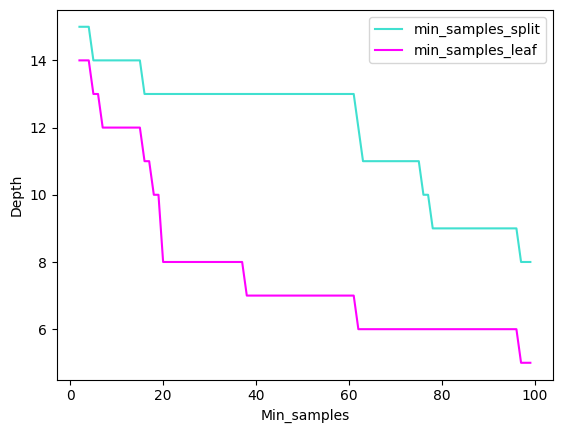

In [8]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7)

depth_min_samples_split = []
depth_min_samples_leaf = []

for min_samples_split in range(2, 100):
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split)
    tree.fit(X_train, y_train)
    depth_min_samples_split.append(tree.get_depth())

for min_samples_leaf in range(2, 100):
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)
    depth_min_samples_leaf.append(tree.get_depth())


plt.plot(range(2, 100), depth_min_samples_split, c='turquoise', label='min_samples_split')
plt.plot(range(2, 100), depth_min_samples_leaf, c='magenta', label='min_samples_leaf')
plt.xlabel('Min_samples')
plt.ylabel('Depth')

plt.legend()
plt.show()

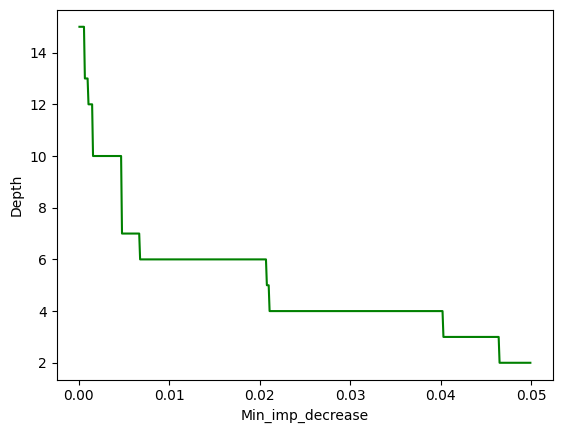

In [9]:
depth_min_imp_decrease = []

for min_imp_decrease in range(1, 500):
    tree = DecisionTreeClassifier(min_impurity_decrease=min_imp_decrease / 10000)
    tree.fit(X_train, y_train)
    depth_min_imp_decrease.append(tree.get_depth())
    
plt.plot([x / 10000 for x in range(1, 500)], depth_min_imp_decrease, c='green')
plt.xlabel('Min_imp_decrease')
plt.ylabel('Depth')

plt.show()

## Подбор гиперпараметров для моих реализаций

In [10]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['none', 'gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 20)
    classifier = DTClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=5
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-17 14:55:47,229] A new study created in memory with name: no-name-47c60c42-bcd9-4373-bf1d-4aa14a54e264
[I 2024-10-17 14:55:55,625] Trial 0 finished with value: 0.6127324782409528 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 3}. Best is trial 0 with value: 0.6127324782409528.
[I 2024-10-17 14:55:59,883] Trial 1 finished with value: 0.9119903802107192 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 16}. Best is trial 1 with value: 0.9119903802107192.
[I 2024-10-17 14:55:59,991] Trial 2 finished with value: 0.16654374713696746 and parameters: {'stopping_criteria': 'none'}. Best is trial 1 with value: 0.9119903802107192.
[I 2024-10-17 14:56:04,290] Trial 3 finished with value: 0.908602840128264 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 9}. Best is trial 1 with value: 0.9119903802107192.
[I 2024-10-17 14:56:04,334] Trial 4 finished with value: 0.16654374713696746 and parameters: {'stoppin

In [9]:
study.best_value, study.best_params

(0.9248511223087494,
 {'stopping_criteria': 'depth_threshold', 'depth_threshold': 15})

In [10]:
def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 10)
    n_trees = trial.suggest_int('n_trees', 2, 25)
    classifier = RFClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold, n_trees)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=5
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-17 14:42:31,920] A new study created in memory with name: no-name-7360374e-fdc2-4326-8c2e-09671063ecea
[I 2024-10-17 14:42:38,325] Trial 0 finished with value: 0.6947411818598259 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 7, 'n_trees': 13}. Best is trial 0 with value: 0.6947411818598259.
[I 2024-10-17 14:42:38,409] Trial 1 finished with value: 0.17942968392120934 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 14, 'n_trees': 13}. Best is trial 0 with value: 0.6947411818598259.
[I 2024-10-17 14:42:38,482] Trial 2 finished with value: 0.17064590013742556 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.4, 'n_trees': 3}. Best is trial 0 with value: 0.6947411818598259.
[I 2024-10-17 14:42:38,605] Trial 3 finished with value: 0.17942968392120934 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 100, 'n_trees': 23}. Best is trial 0 with value: 0.6947411818598259.
[I 2024-1

In [11]:
study.best_value, study.best_params

(0.7670819972514888,
 {'stopping_criteria': 'depth_threshold',
  'depth_threshold': 10,
  'n_trees': 12})

In [33]:
def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['none', 'gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 10)
    n_trees = trial.suggest_int('n_trees', 2, 25)
    classifier = BoostClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold, n_trees)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy'
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, n_jobs=20)

[I 2024-10-17 16:23:36,039] A new study created in memory with name: no-name-8398588f-df07-420a-aa2c-83eadb62f379
[I 2024-10-17 16:23:39,919] Trial 7 finished with value: 0.16856161245991758 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 96, 'n_trees': 3}. Best is trial 7 with value: 0.16856161245991758.
[I 2024-10-17 16:23:41,983] Trial 13 finished with value: 0.16856161245991758 and parameters: {'stopping_criteria': 'none', 'n_trees': 7}. Best is trial 7 with value: 0.16856161245991758.
[I 2024-10-17 16:23:42,450] Trial 4 finished with value: 0.16856161245991758 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 60, 'n_trees': 8}. Best is trial 7 with value: 0.16856161245991758.
[I 2024-10-17 16:23:44,439] Trial 3 finished with value: 0.16856161245991758 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.25, 'n_trees': 13}. Best is trial 7 with value: 0.16856161245991758.
[I 2024-10-17 16:23:44,675] Trial 0 fi

In [34]:
study.best_value, study.best_params

(0.8781310123683005,
 {'stopping_criteria': 'depth_threshold', 'depth_threshold': 9, 'n_trees': 4})

## Подбор гиперпараметров для библиотечных реализаций

In [12]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, step=2)
    classifier = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-17 15:09:55,739] A new study created in memory with name: no-name-ff2992c3-ad19-4fd4-b258-2c343bf88410
[I 2024-10-17 15:09:55,990] Trial 0 finished with value: 0.7975515345854329 and parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 58}. Best is trial 0 with value: 0.7975515345854329.
[I 2024-10-17 15:09:56,125] Trial 1 finished with value: 0.7948396701786533 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 94, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.7975515345854329.
[I 2024-10-17 15:09:56,268] Trial 2 finished with value: 0.7332180485570315 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 20, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.7975515345854329.
[I 2024-10-17 15:09:56,349] Trial 3 finished with value: 0.8009505267979845 and parameters: {'criterion': 'log_loss', 'max_depth': 13, 'min_samples_split': 86, 'min_samples_leaf': 8}. Best is tr

In [13]:
study.best_value, study.best_params

(0.9383967017865322,
 {'criterion': 'log_loss',
  'max_depth': 16,
  'min_samples_split': 14,
  'min_samples_leaf': 2})

In [14]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, step=2)
    n_estimators = trial.suggest_int('n_estimators', 2, 100, step=2)
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-17 15:10:12,008] A new study created in memory with name: no-name-89f93817-2444-4251-afaa-fcd4123712fd
[I 2024-10-17 15:10:14,219] Trial 0 finished with value: 0.44544434264773247 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 44, 'n_estimators': 46}. Best is trial 0 with value: 0.44544434264773247.
[I 2024-10-17 15:10:16,760] Trial 1 finished with value: 0.6547732478240953 and parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 28, 'min_samples_leaf': 98, 'n_estimators': 30}. Best is trial 1 with value: 0.6547732478240953.
[I 2024-10-17 15:10:21,900] Trial 2 finished with value: 0.6607901969766377 and parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 98, 'n_estimators': 88}. Best is trial 2 with value: 0.6607901969766377.
[I 2024-10-17 15:10:25,752] Trial 3 finished with value: 0.7440494732020155 and parameters: {'criterion': 'log_loss', 'max_depth': 

In [15]:
study.best_value, study.best_params

(0.9126591846083372,
 {'criterion': 'entropy',
  'max_depth': 11,
  'min_samples_split': 22,
  'min_samples_leaf': 2,
  'n_estimators': 74})

In [16]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100, step=2)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 10, log=True)
    classifier = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(criterion='entropy', max_depth=14),
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        algorithm='SAMME'
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-17 15:11:58,351] A new study created in memory with name: no-name-bc32c327-b923-4432-b7ba-944af80478f1
[I 2024-10-17 15:11:58,740] Trial 0 finished with value: 0.9404168575355015 and parameters: {'n_estimators': 96, 'learning_rate': 1.3735608385591969}. Best is trial 0 with value: 0.9404168575355015.
[I 2024-10-17 15:11:58,927] Trial 1 finished with value: 0.9377141548327987 and parameters: {'n_estimators': 22, 'learning_rate': 2.3703218771478953}. Best is trial 0 with value: 0.9404168575355015.
[I 2024-10-17 15:11:59,049] Trial 2 finished with value: 0.9417773705909299 and parameters: {'n_estimators': 30, 'learning_rate': 0.006628761556231837}. Best is trial 2 with value: 0.9417773705909299.
[I 2024-10-17 15:11:59,184] Trial 3 finished with value: 0.9397457627118644 and parameters: {'n_estimators': 18, 'learning_rate': 0.014787753099707111}. Best is trial 2 with value: 0.9417773705909299.
[I 2024-10-17 15:11:59,342] Trial 4 finished with value: 0.9363536417773707 and parame

In [17]:
study.best_value, study.best_params

(0.9444800732936326, {'n_estimators': 52, 'learning_rate': 0.032034892423716})

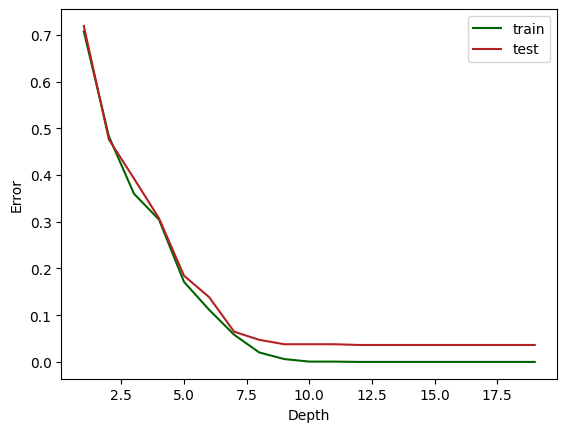

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7)

train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for depth in range(1, 20):
    model = DTClassifier(stopping_criteria="depth_threshold", depth_threshold=depth)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = DecisionTreeClassifier(max_depth=depth)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(1, 20), train_err, c='darkgreen', label='train')
plt.plot(range(1, 20), test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

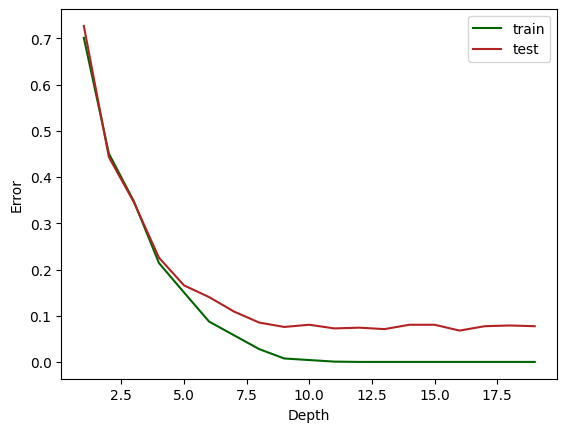

In [19]:
plt.plot(range(1, 20), lib_train_err, c='darkgreen', label='train')
plt.plot(range(1, 20), lib_test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

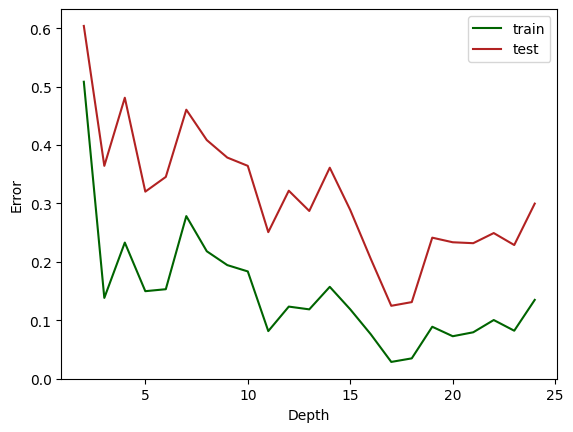

In [21]:
train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for trees in range(2, 25):
    model = RFClassifier(stopping_criteria="depth_threshold", depth_threshold=10, n_trees=trees)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = RandomForestClassifier(max_depth=10, n_estimators=trees)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(2, 25), train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

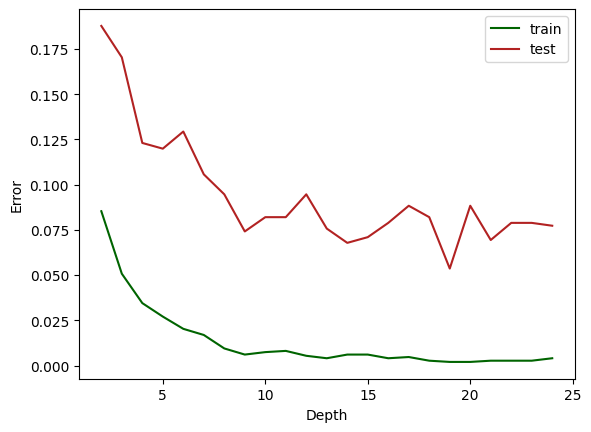

In [22]:
plt.plot(range(2, 25), lib_train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), lib_test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

/Users/macbook/Desktop/ITMO/sixth-semestr/ML/cftasks/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/macbook/Desktop/ITMO/sixth-semestr/ML/cftasks/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/macbook/Desktop/ITMO/sixth-semestr/ML/cftasks/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/macbook/Desktop/ITMO/sixth-semestr/ML/cftasks/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527

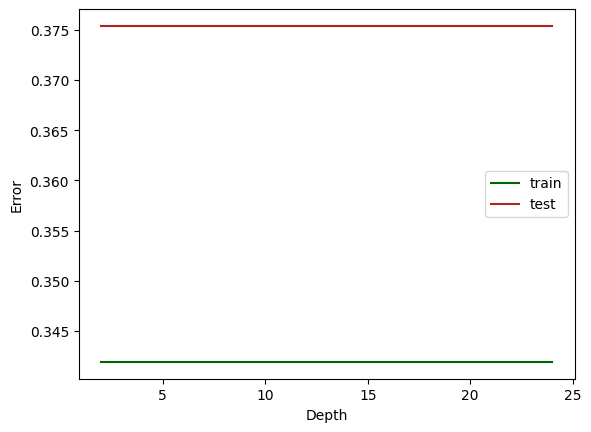

In [25]:
train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for trees in range(2, 25):
    model = BoostClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=trees)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=trees)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(2, 25), train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()

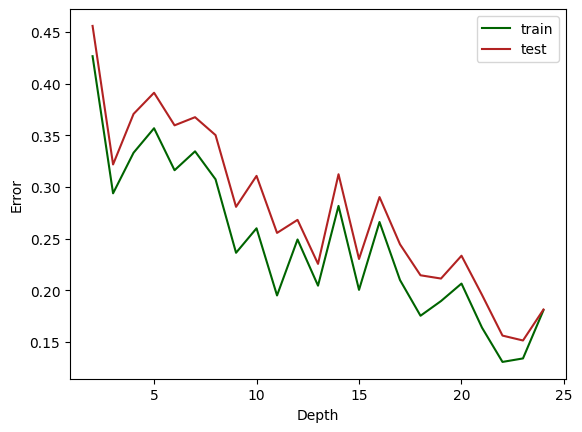

In [26]:
plt.plot(range(2, 25), lib_train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), lib_test_err, c='firebrick', label='test')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.legend()
plt.show()